# 01.10 - BEE-NOBEE - SVM Classification

## Prerequisites

- The dataset exists (if not, execute 01.01)
- The dataset features have been populated (if not, execute 01.02)


In [1]:
import warnings                              # This block prevents display of harmless warnings, but should be
warnings.filterwarnings('ignore')            # commented out till the experiment final version,
                                             # in order to avoid missing "real" warnings 
from IPython.display import display
import kilroy_was_here                       # Mandatory. Allow access to shared python code from repository root
from audace.jupytools import iprint
from audace.audiodataset import AudioDataset # Main class for audio dataset handling

# Experiment name will be used to prefix potential outputs
EXP_NAME = "01.10 - BEE-NOBEE - SVM Classification"

# Dataset name is the master key for dataset adressing
# Change it according to the dataset you want to process
DATASET_NAME = 'MAIN1000'

# Initialize Dataset Object. 
ds = AudioDataset(DATASET_NAME)
    
# Display AudioDataset summary    
ds.info()

[2020-08-26/10:33:50.356|14.7%|81.2%|0.26GB] ------------------------------------------------------
[2020-08-26/10:33:50.357|00.0%|81.2%|0.26GB] DATASET NAME          : MAIN1000
[2020-08-26/10:33:50.357|00.0%|81.2%|0.26GB] DATASET PATH          : D:\Jupyter\ShowBees\datasets\MAIN1000
[2020-08-26/10:33:50.357|00.0%|81.2%|0.26GB] DATASET DB PATH       : D:\Jupyter\ShowBees\datasets\MAIN1000\MAIN1000.db
[2020-08-26/10:33:50.357|00.0%|81.2%|0.26GB] DATASET SAMPLES PATH  : D:\Jupyter\ShowBees\datasets\MAIN1000\samples
[2020-08-26/10:33:50.357|00.0%|81.2%|0.26GB] NB SOURCE AUDIO FILES : 48
[2020-08-26/10:33:50.357|00.0%|81.2%|0.26GB] SAMPLE RATE           : 22050
[2020-08-26/10:33:50.357|00.0%|81.2%|0.26GB] DURATION              : 1.0
[2020-08-26/10:33:50.358|00.0%|81.2%|0.26GB] OVERLAP               : 0.0
[2020-08-26/10:33:50.358|00.0%|81.2%|0.26GB] NB AUDIO CHUNKS       : 24788
[2020-08-26/10:33:50.358|00.0%|81.2%|0.26GB] ------------------------------------------------------


In [3]:
# label as no bee only if at least 50% of chunck is noisy
NOISE_THRESHOLD = 0.5

# Display cardinalities by hive attribute and binary nobee label
sql = F"""
    select distinct hive, iif(nobee > {NOISE_THRESHOLD} , 1, 0) as b_nobee , count(*)
    from samples
    group by hive, b_nobee 
    order by hive
    """
display(ds.queryDataFrame(sql))

,hive,b_nobee,count(*)
0,CF001,0,15
1,CF003,0,3760
2,CF003,1,440
3,CJ001,0,960
4,CJ001,1,540
5,GH001,0,1494
6,GH001,1,1630
7,Hive1,0,4413
8,Hive1,1,1545
9,Hive3,0,7412


In [4]:
import numpy as np
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from audace.jupytools import predestination
from audace.audiodataset import feature_serie_to_flat_np

# Experiment parameters
FEATURE_NAME = 'mfcc20'
SET_FRAC = 1
TEST_FRAC = 0.3
KERNEL = 'rbf'
C = 1
GAMMA = 'scale'

# Seed the various PRNGs
predestination()

# Get pandas dataframe containing the columns we will need for this experiments,
# shuffle it (and potentially truncate it to speed quick tests)
iprint('>>>>> Query')
sql = F"select {FEATURE_NAME}, iif(nobee >{NOISE_THRESHOLD} , 1, 0) as b_nobee from samples"
df = ds.queryDataFrame(sql).sample(frac=SET_FRAC)

# flatten features array
iprint('>>>>> Flatten')
X = feature_serie_to_flat_np(df[FEATURE_NAME])

# get labels
y = df['b_nobee']

# Partition dataset into training and test subsets
iprint('>>>>> Partition')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_FRAC)

# It is usually a good idea to scale the data for SVM training. Classifiers usually
#perform better on normalized data
iprint('>>>>> Scale')
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Create a svm Classifier, using the experiment parameters
clf = svm.SVC(kernel=KERNEL, C=C, gamma=GAMMA)

iprint('>>>>> Train')
#Train the model using the training sets
clf.fit(X_train, y_train)

iprint('>>>>> Predict')
#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Display information about the classifier performance
iprint(F"Trained over {len(y_train)} / Tested over {len(y_test)}")
iprint("Accuracy  :",metrics.accuracy_score(y_test, y_pred))
iprint("Precision :",metrics.precision_score(y_test, y_pred))
iprint("Recall    :",metrics.recall_score(y_test, y_pred))
iprint("F-Measure :",metrics.f1_score(y_test, y_pred))


[2020-08-26/10:36:00.378|05.5%|80.8%|0.27GB] >>>>> Query
[2020-08-26/10:36:00.851|14.2%|82.9%|0.36GB] >>>>> Flatten
[2020-08-26/10:36:00.956|20.0%|83.9%|0.44GB] >>>>> Partition
[2020-08-26/10:36:01.009|18.8%|84.9%|0.52GB] >>>>> Scale
[2020-08-26/10:36:01.429|25.7%|85.0%|0.52GB] >>>>> Train
[2020-08-26/10:42:07.709|17.1%|85.6%|0.59GB] >>>>> Predict
[2020-08-26/10:43:29.147|16.7%|86.4%|0.59GB] Trained over 17351 / Tested over 7437
[2020-08-26/10:43:29.149|00.0%|86.4%|0.59GB] Accuracy  : 0.8062390748957913
[2020-08-26/10:43:29.163|00.0%|86.4%|0.59GB] Precision : 0.7605760576057605
[2020-08-26/10:43:29.166|00.0%|86.4%|0.59GB] Recall    : 0.4183168316831683
[2020-08-26/10:43:29.169|00.0%|86.4%|0.59GB] F-Measure : 0.5397636537847333


In [14]:
for hive in ds.listAttributeValues('hive'):
    hive_df = ds.queryDataFrame(F"select {FEATURE_NAME}, queen from samples where nobee = 0 and hive = '{hive}'").sample(frac=0.5)
    hive_X = scaler.transform(feature_serie_to_flat_np(hive_df[FEATURE_NAME]))
    hive_y = hive_df['b_nobee']
    hive_y_pred = clf.predict(hive_X)
    print(hive, metrics.accuracy_score(hive_y, hive_y_pred))
    



CF001 1.0
GH001 0.21279761904761904
CF003 0.9253979312932097
CJ001 0.989247311827957
Hive1 0.6361434772675348
Hive3 0.5565351434675609


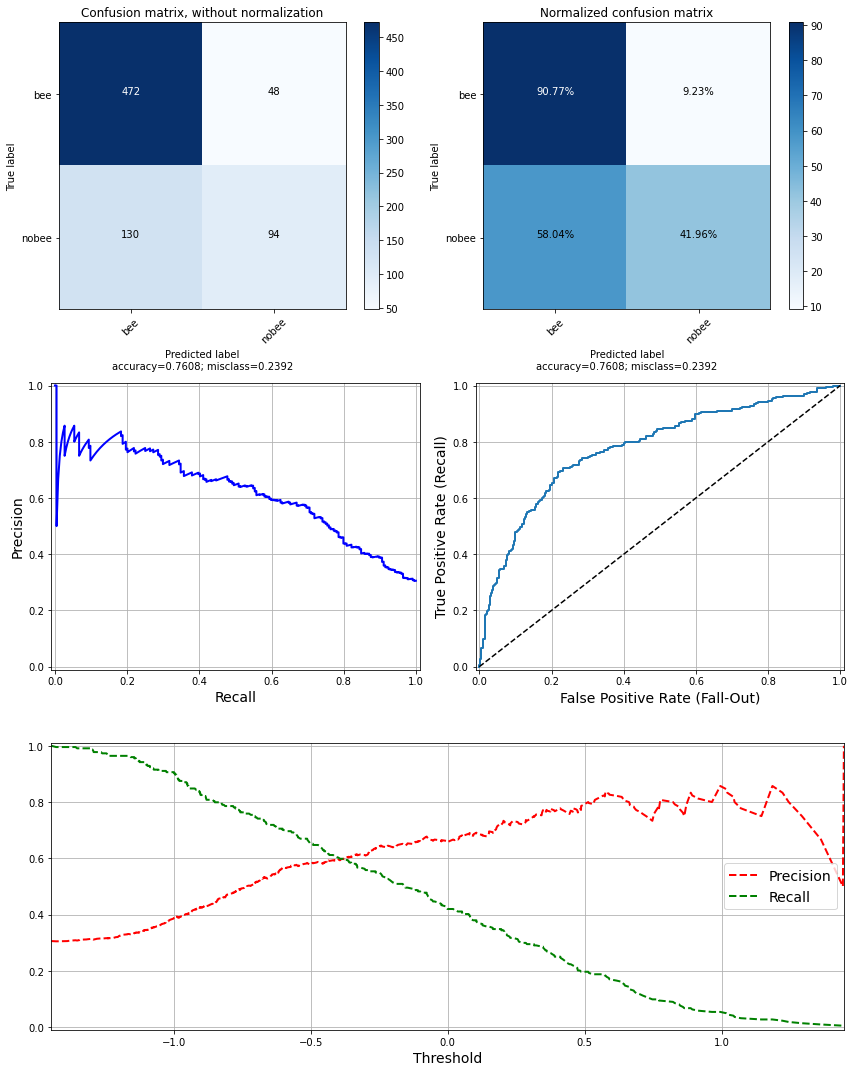

------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         bee       0.78      0.91      0.84       520
       nobee       0.66      0.42      0.51       224

    accuracy                           0.76       744
   macro avg       0.72      0.66      0.68       744
weighted avg       0.75      0.76      0.74       744

------------------------------------------------------------------------------------------
Area Under ROC Curve 0.7782795329670331
------------------------------------------------------------------------------------------


In [13]:
from audace.plotters import clf_full_report
from sklearn import metrics

target_names = ['bee', 'nobee']

tst = int(100*TEST_FRAC)
trn = 100 -tst

figure_name = F"Full Report {KERNEL} - ({DATASET_NAME}) - [Trn{trn:02d},Tst{tst:02d}] - C{C}"
if KERNEL != 'linear':
    figure_name += F" - G{GAMMA}"

clf_full_report(clf, X_test, y_test, target_names, EXP_NAME, figure_name)


print("------------------------------------------------------------------------------------------")
print(metrics.classification_report(y_test, y_pred , target_names=target_names))
print("------------------------------------------------------------------------------------------")
print('Area Under ROC Curve', metrics.roc_auc_score(y_test, clf.decision_function(X_test)))
print("------------------------------------------------------------------------------------------")

-------------------------------------
Accuracy: 0.24350550702620585
Precision: 0.6666666666666666
Recall: 2.510197678067148e-05
F1: 5.0202063304801835e-05


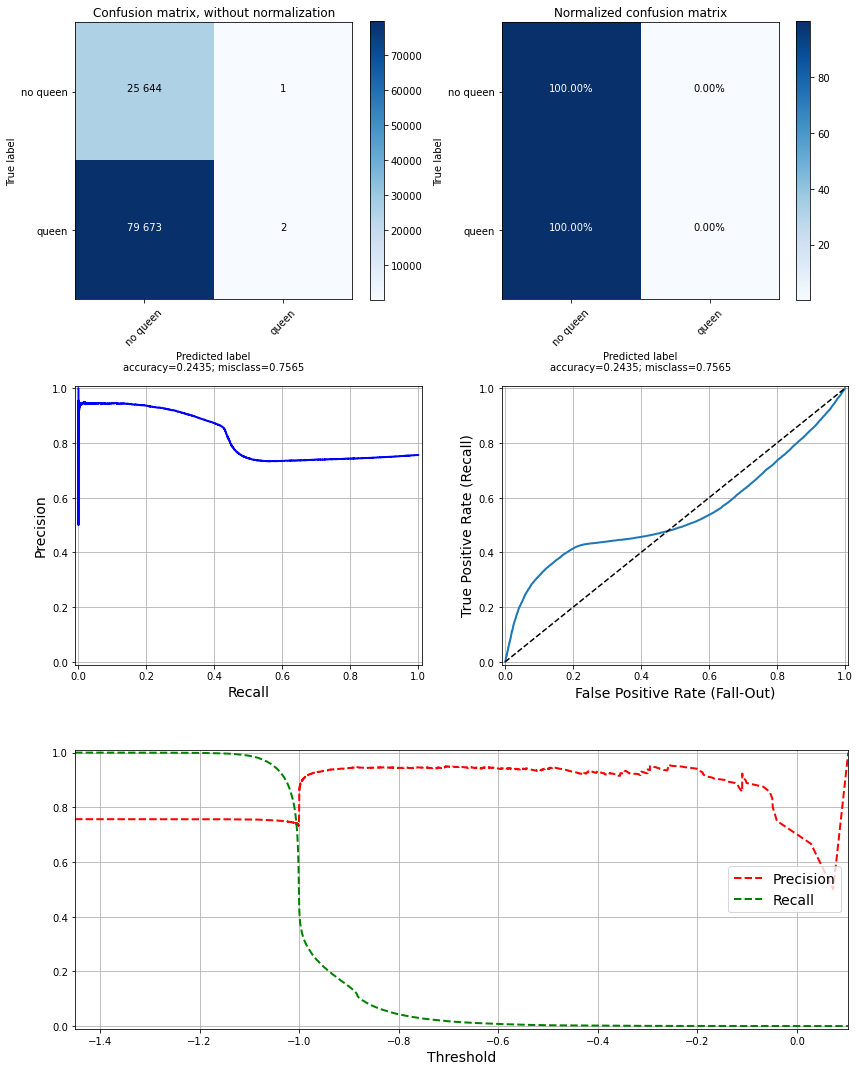

In [ ]:
from sklearn import svm
from sklearn import metrics
from audace.plotters import clf_full_report
from sklearn.preprocessing import StandardScaler

FEATURE_NAME = 'mfcc20'
KERNEL = 'rbf'
C = 1
GAMMA = 'scale'
TRAIN_FRAC = 0.5
target_names = ['bee', 'nobee']

df_fold1 = ds.queryDataFrame(F"select {FEATURE_NAME}, queen from samples where nobee = 0 and hive = 'Hive3'").sample(frac=1)
df_fold2 = ds.queryDataFrame(F"select {FEATURE_NAME}, queen from samples where nobee = 0 and hive != 'Hive3'").sample(frac=1)




def process_svm(X_train_serie, y_train, X_test_serie, y_test):
    X_train = feature_serie_to_flat_np(X_train_serie)
    X_test = feature_serie_to_flat_np(X_test_serie)

    #Create a svm Classifier
    clf = svm.SVC(kernel=KERNEL, C=C, gamma=GAMMA)

    scaler = StandardScaler()    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)    
    
    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("-------------------------------------")
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Precision:",metrics.precision_score(y_test, y_pred))
    print("Recall:",metrics.recall_score(y_test, y_pred))
    print("F1:",metrics.f1_score(y_test, y_pred))
    
    return clf, X_test, y_test


df_train = df_fold1.sample(frac = TRAIN_FRAC)
df_test = df_fold2

c, X, y = process_svm(df_train[FEATURE_NAME], df_train['queen'], df_test[FEATURE_NAME], df_test['queen'])
clf_full_report(c, X, y, target_names)

df_train = df_fold2.sample(frac = TRAIN_FRAC)
df_test = df_fold1
c, X, y = process_svm(df_train[FEATURE_NAME], df_train['queen'], df_test[FEATURE_NAME], df_test['queen'])
clf_full_report(c, X, y, target_names)

